In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)


# Optimisation imports
import zodiax as zdx
import optax
import optimistix as optx

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *
from spectra import *

import jax.tree_util as jtu
import interpax as ipx

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [4]:
wid = 90
oversample = 4

nwavels = 20#13#6
npoly=15#2

n_zernikes = 30#30#12

optics = NICMOSSecondaryFresnelOptics(512, wid, oversample, mag=3.3, defocus=0., despace=0., n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

basis_file = np.load("spectrum_basis.npy")[:,:npoly]

spectrum_basis = ipx.interp1d(np.linspace(0,1,nwavels), np.linspace(0,1,basis_file.shape[0]), basis_file)
spectrum_basis = spectrum_basis/np.sqrt(np.mean(spectrum_basis**2, axis=0))

#spectrum_basis = build_dct_basis(nwavels, npoly)



ddir = "../data/MAST_2025-12-15T00_12_09.074Z/HST/"

exposures_single = [
    #exposure_from_file(ddir + "n8yj63wnq_cal.fits", SinglePointFit(spectrum_basis, "F110W"), crop=wid),
    #exposure_from_file(ddir + "n8yj63wnq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 5), crop=wid),
    exposure_from_file(ddir + "n9nk05mfq_cal.fits", SinglePointFit(spectrum_basis, "F110W"), crop=wid),
    
    #exposure_from_file(ddir + "n8yj63wlq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 5), crop=wid),
    #exposure_from_file(ddir + "n8yj63wmq_cal.fits", SinglePointFit(CombinedFourierSpectrum, 15), crop=wid),
]


ddir = "../data/MAST_2024-09-26T22_53_13.719Z/HST/"

exposures_single = [
    exposure_from_file(ddir + "n8ry01tkq_cal.fits", SinglePointFit(spectrum_basis, "F110W"), crop=wid),
    exposure_from_file(ddir + "n8ry01tmq_cal.fits", SinglePointFit(spectrum_basis, "F110W"), crop=wid),
    #exposure_from_file(ddir + "n8ry02tpq_cal.fits", SinglePointFit(spectrum_basis, "F110W"), crop=wid),
    #exposure_from_file(ddir + "n8ry02tqq_cal.fits", SinglePointFit(spectrum_basis, "F110W"), crop=wid),

    exposure_from_file(ddir + "n8ry03vbq_cal.fits", SinglePointFit(spectrum_basis, "F160W"), crop=wid),
    exposure_from_file(ddir + "n8ry03vcq_cal.fits", SinglePointFit(spectrum_basis, "F160W"), crop=wid),
    ##exposure_from_file(ddir + "n8ry04vfq_cal.fits", SinglePointFit(spectrum_basis, "F160W"), crop=wid),
    #exposure_from_file(ddir + "n8ry04vgq_cal.fits", SinglePointFit(spectrum_basis, "F160W"), crop=wid),
]


183 67
207 60
207 187
207 60
207 187


/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/notebooks/../models.py:163: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return Exposure(filename, name, filter, tf(data), tf(err_with_poisson), tf(bad_with_poisson), fit, mjd, exptime, wcs, pam)
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/notebooks/../models.py:163: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return Exposure(filename, name, filter, tf(data), tf(err_with_poisson), tf(bad_with_poisson), fit, mjd, exptime, wcs, pam)
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/notebooks/../models.py:163: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  return Exposure(filename, name, filter, tf(data), tf(err_with_poisson), tf(bad_with_poisson), fit, mjd, exptime, wc

In [5]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)
    print(e.exptime)

52947.50036751
HZ4
F110W
319.9581
52947.50467306
HZ4
F110W
319.9581
52947.56708054
HZ4
F160W
319.9581
52947.57138609
HZ4
F160W
319.9581


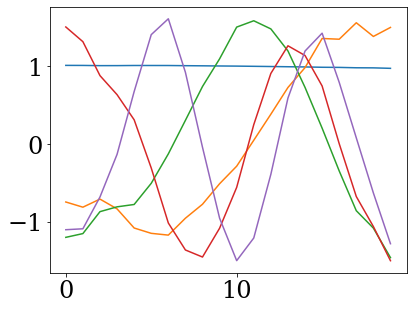

In [6]:
plt.plot(spectrum_basis[:, :5])

In [7]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},

    "defocus": {},#1e5#{}
    "despace": {},
    "mag": 3.3,
}

positions = [[0.,0.,],[0.,0.,],[0.,0.,],[0.,0.,]]#[[0.43251792, 0.33013815],[ 0.49417186, -0.5629123 ]]


for idx, exp in enumerate(exposures_single):
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])#positions_dict[exp.fit.get_key(exp, "positions")]#np.asarray(positions[idx])#np.asarray([0.49162114, -0.5632928])#np.asarray([ 0.45184505, -0.8391668 ])#np.asarray([-0.2,0.4])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = (np.zeros(npoly)).at[0].set(np.log10(np.nansum(exp.data)/nwavels))#np.asarray([-1.03646245, -0.29984712, -0.14137265, -0.04618831, -0.05788671, -0.02545625,
 #-0.03688181,  0.0231736,   0.02356589, -0.00177967]).at[0].set(np.log10(np.nansum(exp.data)/nw[idx]))#np.zeros(nspec[idx]).at[0].set(1)*np.log10(np.nansum(exp.data)/nw[idx])#np.ones(npoly)*np.log10(np.nansum(exp.data)/nwavels)#(np.zeros(npoly)).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(n_zernikes)#np.asarray([0., 24.884588  , -25.489779  , -17.15699   , -21.790146  ,
    #      -4.592212  ,  -4.832893  ,  19.196083  ,   0.37983412,
    #       7.0756216 ,   0.30277824,  -6.330534])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([6.,6.])#np.asarray([9.599048, 6.196583])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    params["defocus"][exp.fit.get_key(exp, "defocus")] = 0.#-0.233#2.4#800.#160.*20
    params["despace"][exp.fit.get_key(exp, "despace")] = 0.#2.4#800.#160.*20
    

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [8]:
print(np.nansum(exp.data))

1001.91864


In [9]:
np.log10(7336/np.sum(10**spectrum_basis[:,0]))

Array(1.5643407, dtype=float32)

In [10]:
print(params.params)

{'positions': {'n8ry01tkq': Array([0., 0.], dtype=float32), 'n8ry01tmq': Array([0., 0.], dtype=float32), 'n8ry03vbq': Array([0., 0.], dtype=float32), 'n8ry03vcq': Array([0., 0.], dtype=float32)}, 'spectrum': {'HZ4_F110W': Array([1.9422408, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       ], dtype=float32), 'HZ4_F160W': Array([1.6998024, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       ], dtype=float32)}, 'aberrations': {'n8ry01tkq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'n8ry01tmq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'n8ry03vbq': A

21.85794
11.9205885
14.895487
7.9587083


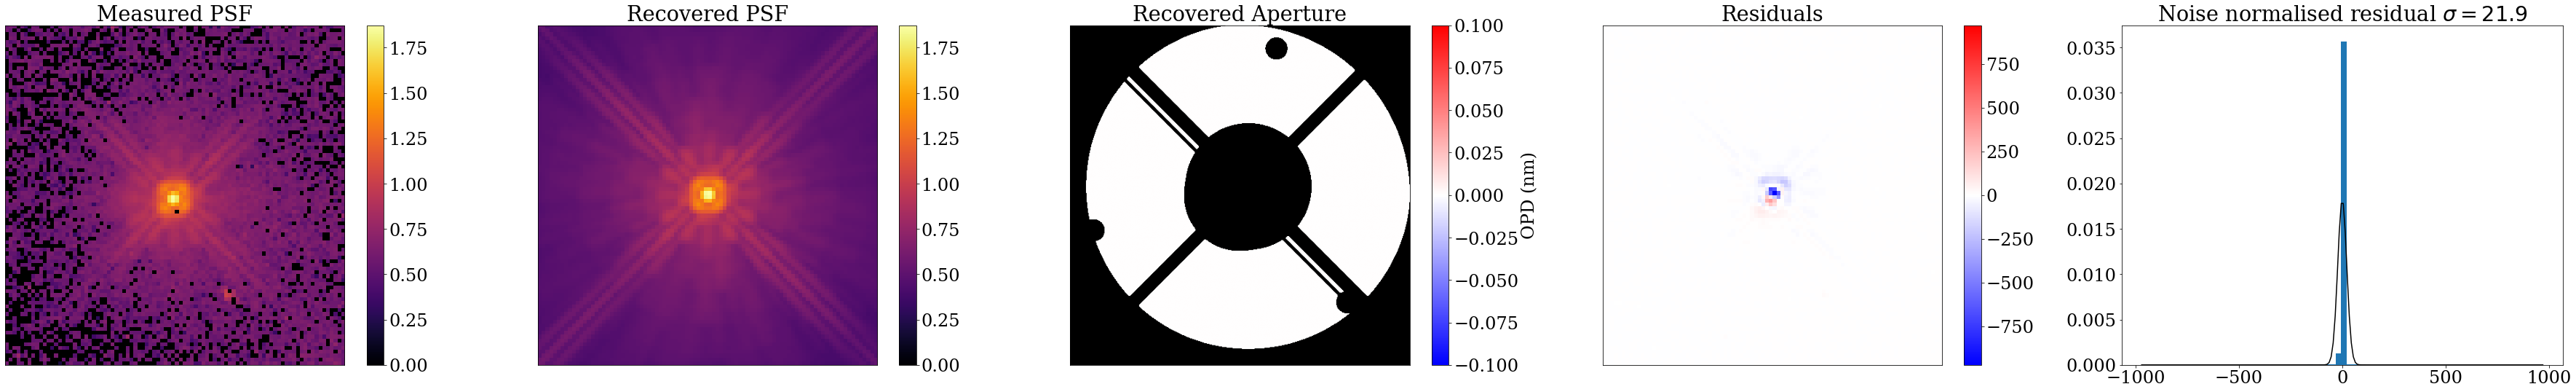

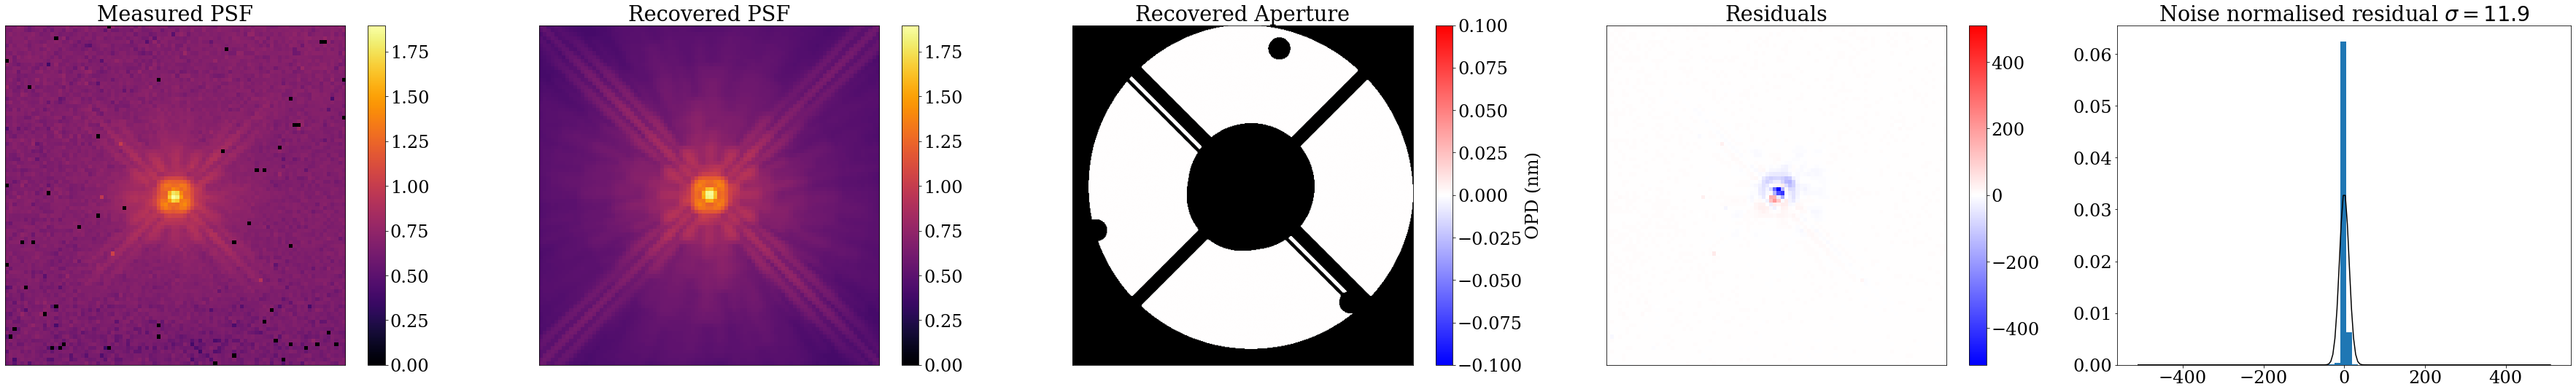

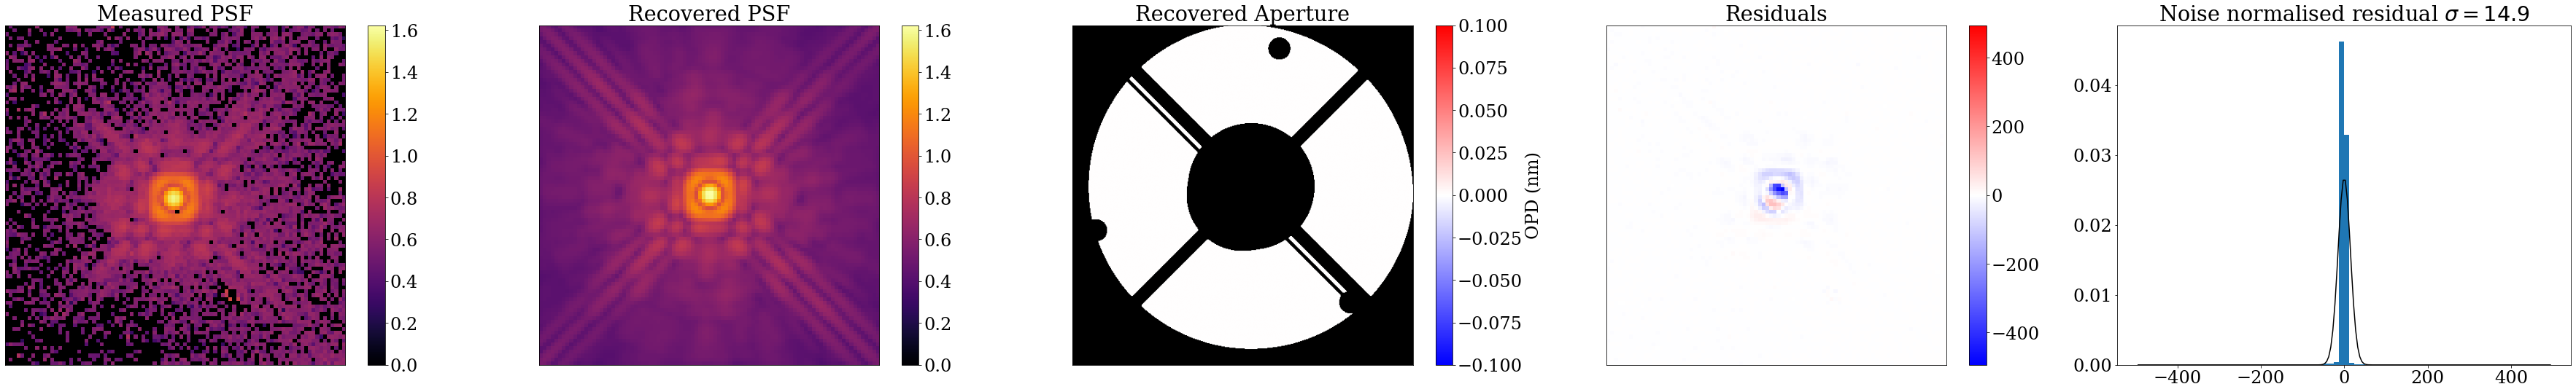

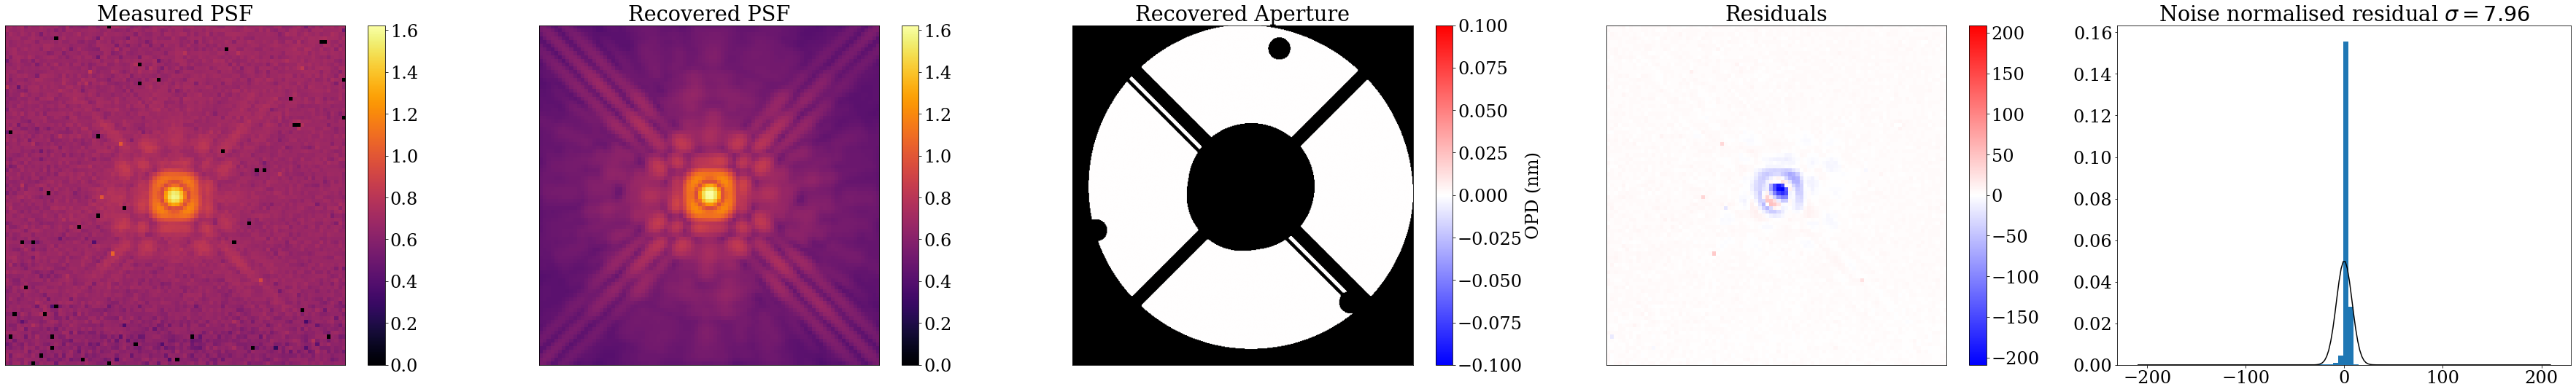

In [11]:
plot_comparison(model_single, params, exposures_single)

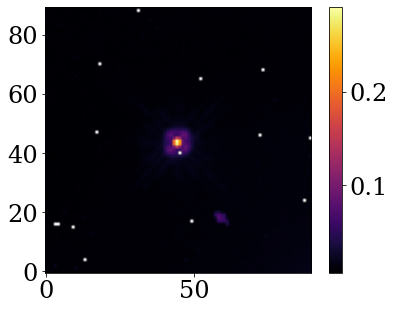

In [12]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

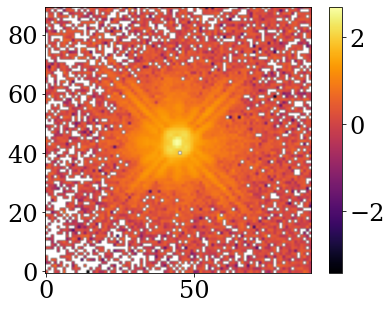

In [13]:
plt.imshow(np.log10(exposures_single[0].data/exposures_single[0].err))
plt.colorbar()

In [14]:
print(exposures_single[0].exptime)

319.9581


([], [])

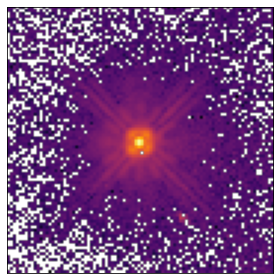

In [15]:
plt.imshow(exposures_single[0].data**0.125)
plt.xticks([])
plt.yticks([])

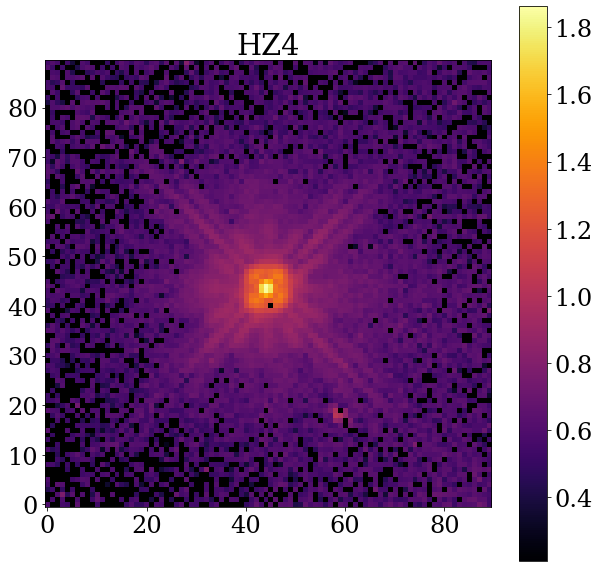

In [16]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [17]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_sgd2 = lambda vals: optax.noisy_sgd(vals)

opts = lambda lr, start, *schedule: base_sgd2(scheduler(lr, start, *schedule))


base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))





def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*1, 10),#opt(g*2, 10),#opt(g*2, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*1, 30),
    
    "bias": opt(g*3, 20),
    "aberrations": opt(g*0.05, 80),
    #"jitter": opt(g*1, 120),

    "despace": opt(g*0.8, 50),
    "mag": opt(g*10, 100),

    #"cold_mask_scale": opt(g*0.1, 100),
    #"cold_mask_shear": opt(g*0.1, 100),
    #"primary_scale": opt(g*1, 100),
    #"primary_shear": opt(g*1, 100),
}

things_start = {
    "positions": opt(g*5, 0),
}

groups = list(things.keys())

In [18]:
initial_losses, initial_models = optimise(params, model_single, exposures_single, things_start, 10, recalculate=True)

Calculating Fishers


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/10 [00:00<?, ?it/s]

4.567922
4.7775044
4.7266536
4.958433


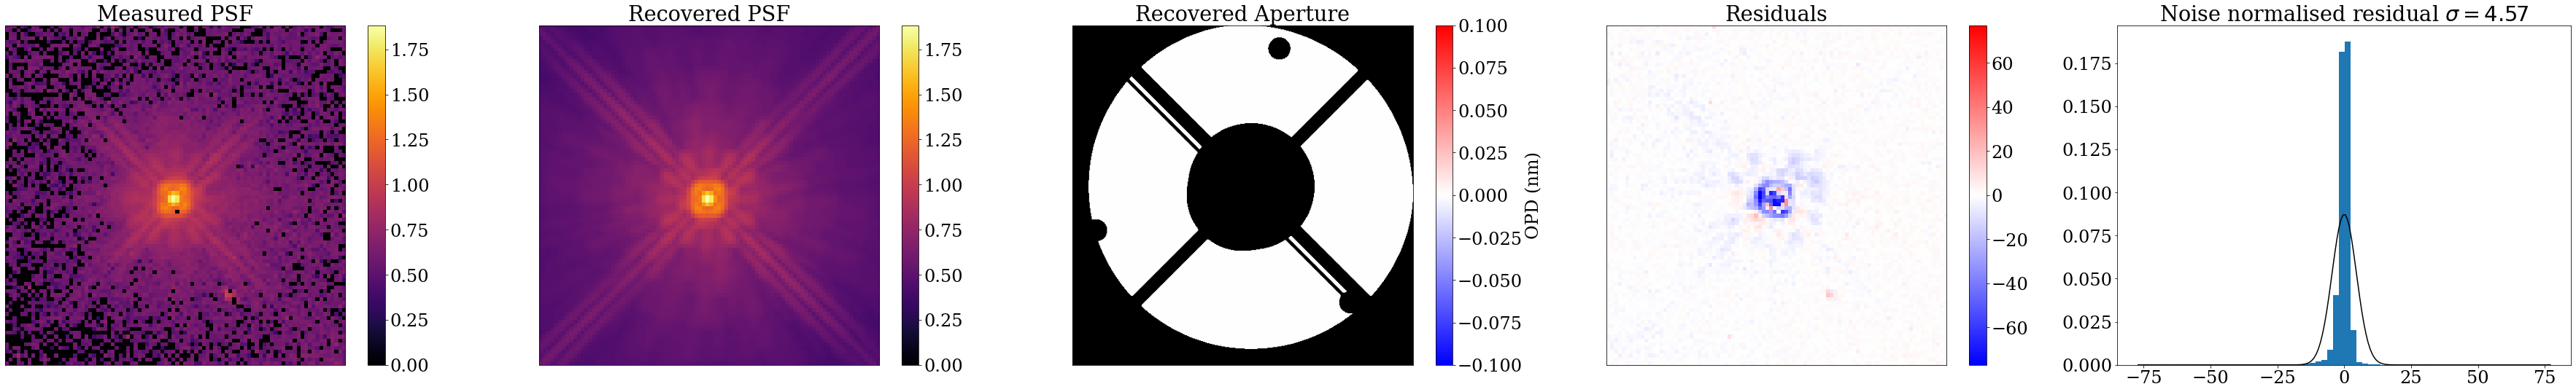

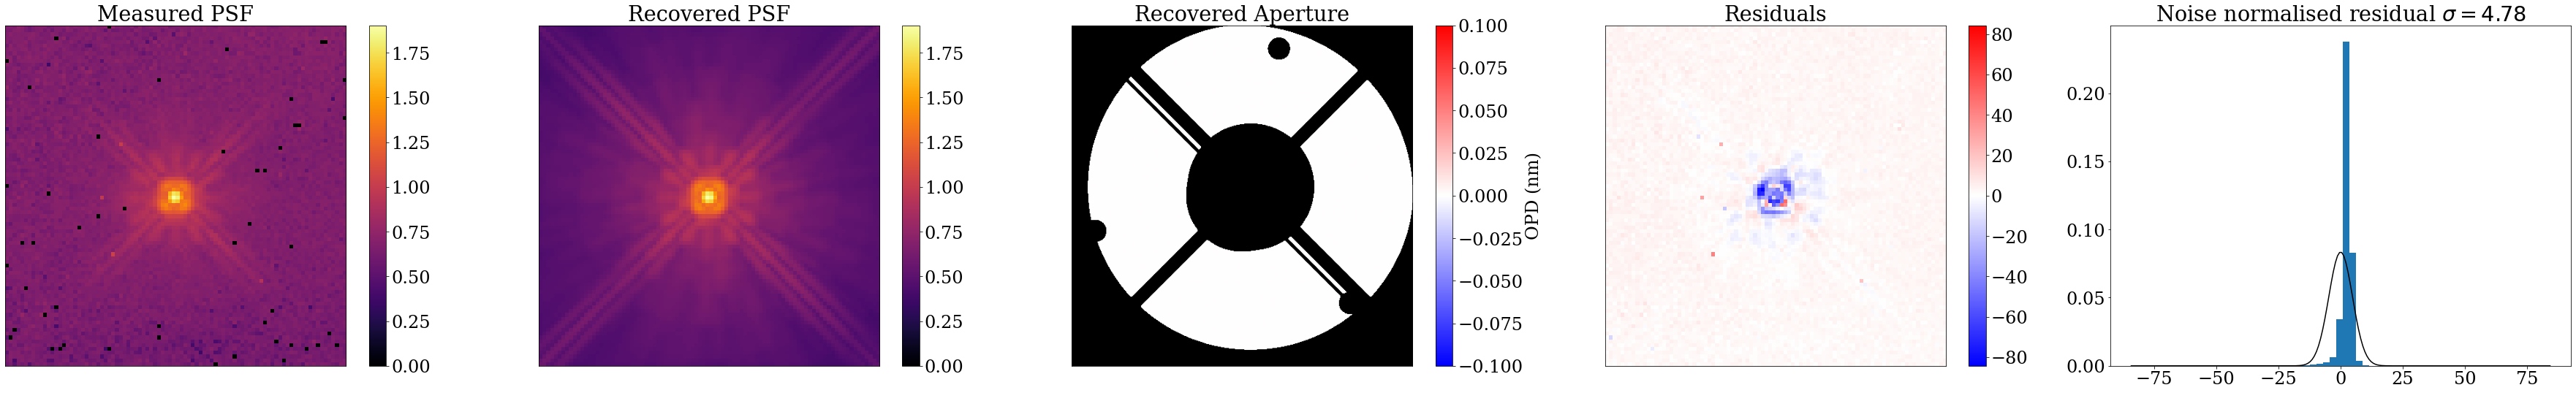

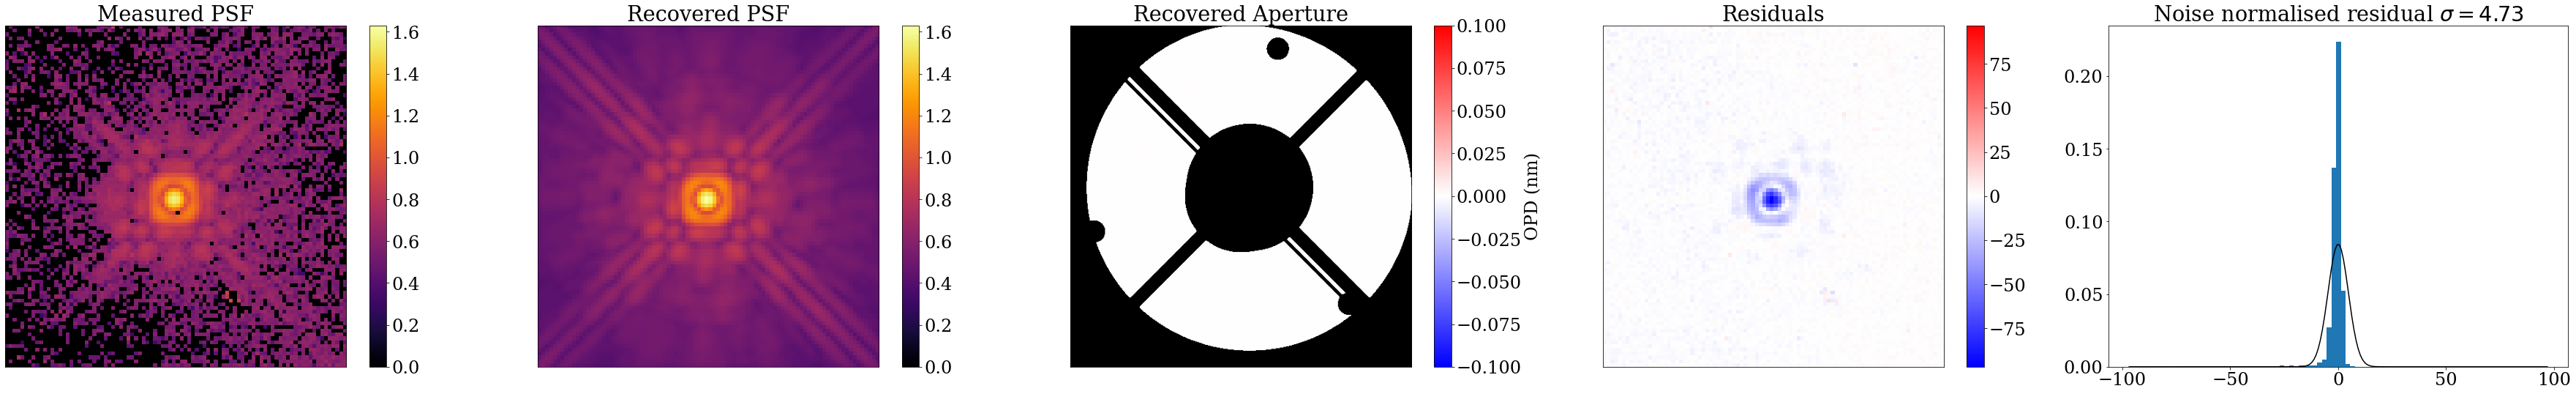

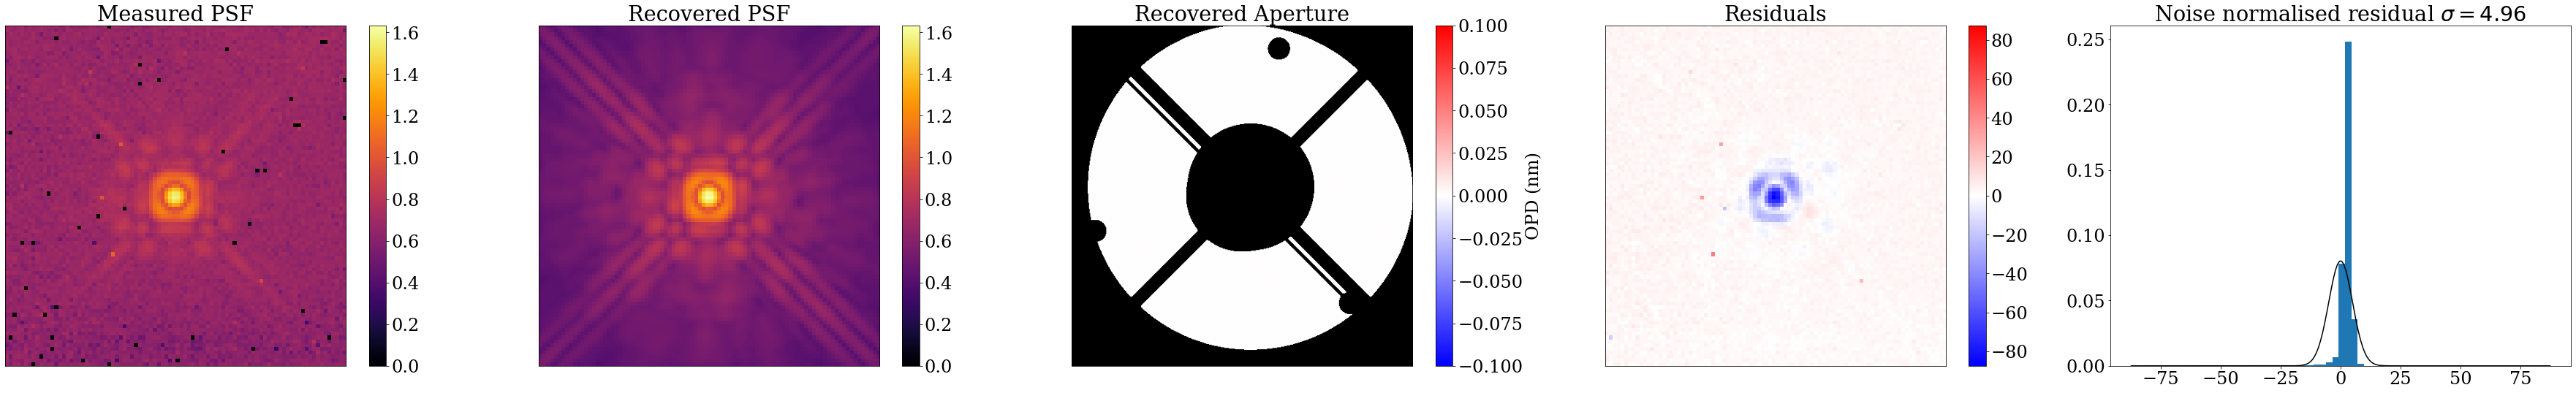

In [19]:
plot_comparison(model_single, initial_models[-1], exposures_single)

In [20]:
initial_models[-1].params

{'positions': {'n8ry01tkq': Array([0.49856493, 1.0866661 ], dtype=float32),
  'n8ry01tmq': Array([0.31453285, 0.5009192 ], dtype=float32),
  'n8ry03vbq': Array([0.51247114, 1.0078112 ], dtype=float32),
  'n8ry03vcq': Array([0.32109502, 0.42192197], dtype=float32)}}

In [21]:
losses, models = optimise(initial_models[-1].inject(params), initial_models[-1].inject(model_single), exposures_single, things, 100, recalculate=True)
#losses, models = optimise(params, model_single, exposures_single, things, 150, recalculate=False)

Calculating Fishers


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting Model


  0%|          | 0/100 [00:00<?, ?it/s]

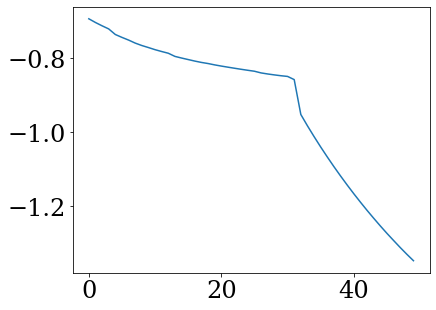

In [22]:
plt.plot(np.asarray(losses[-50:])/(len(exposures_single)*wid**2))

In [23]:
print(losses[0], losses[-1])

293007.44 -43674.27


In [24]:
models_pd = [jax.tree.map(lambda x,y: (x-y)/y, models[i], models[-1]) for i in range(len(models))]

7
2.2938972
2.467988
1.6873746
1.855579


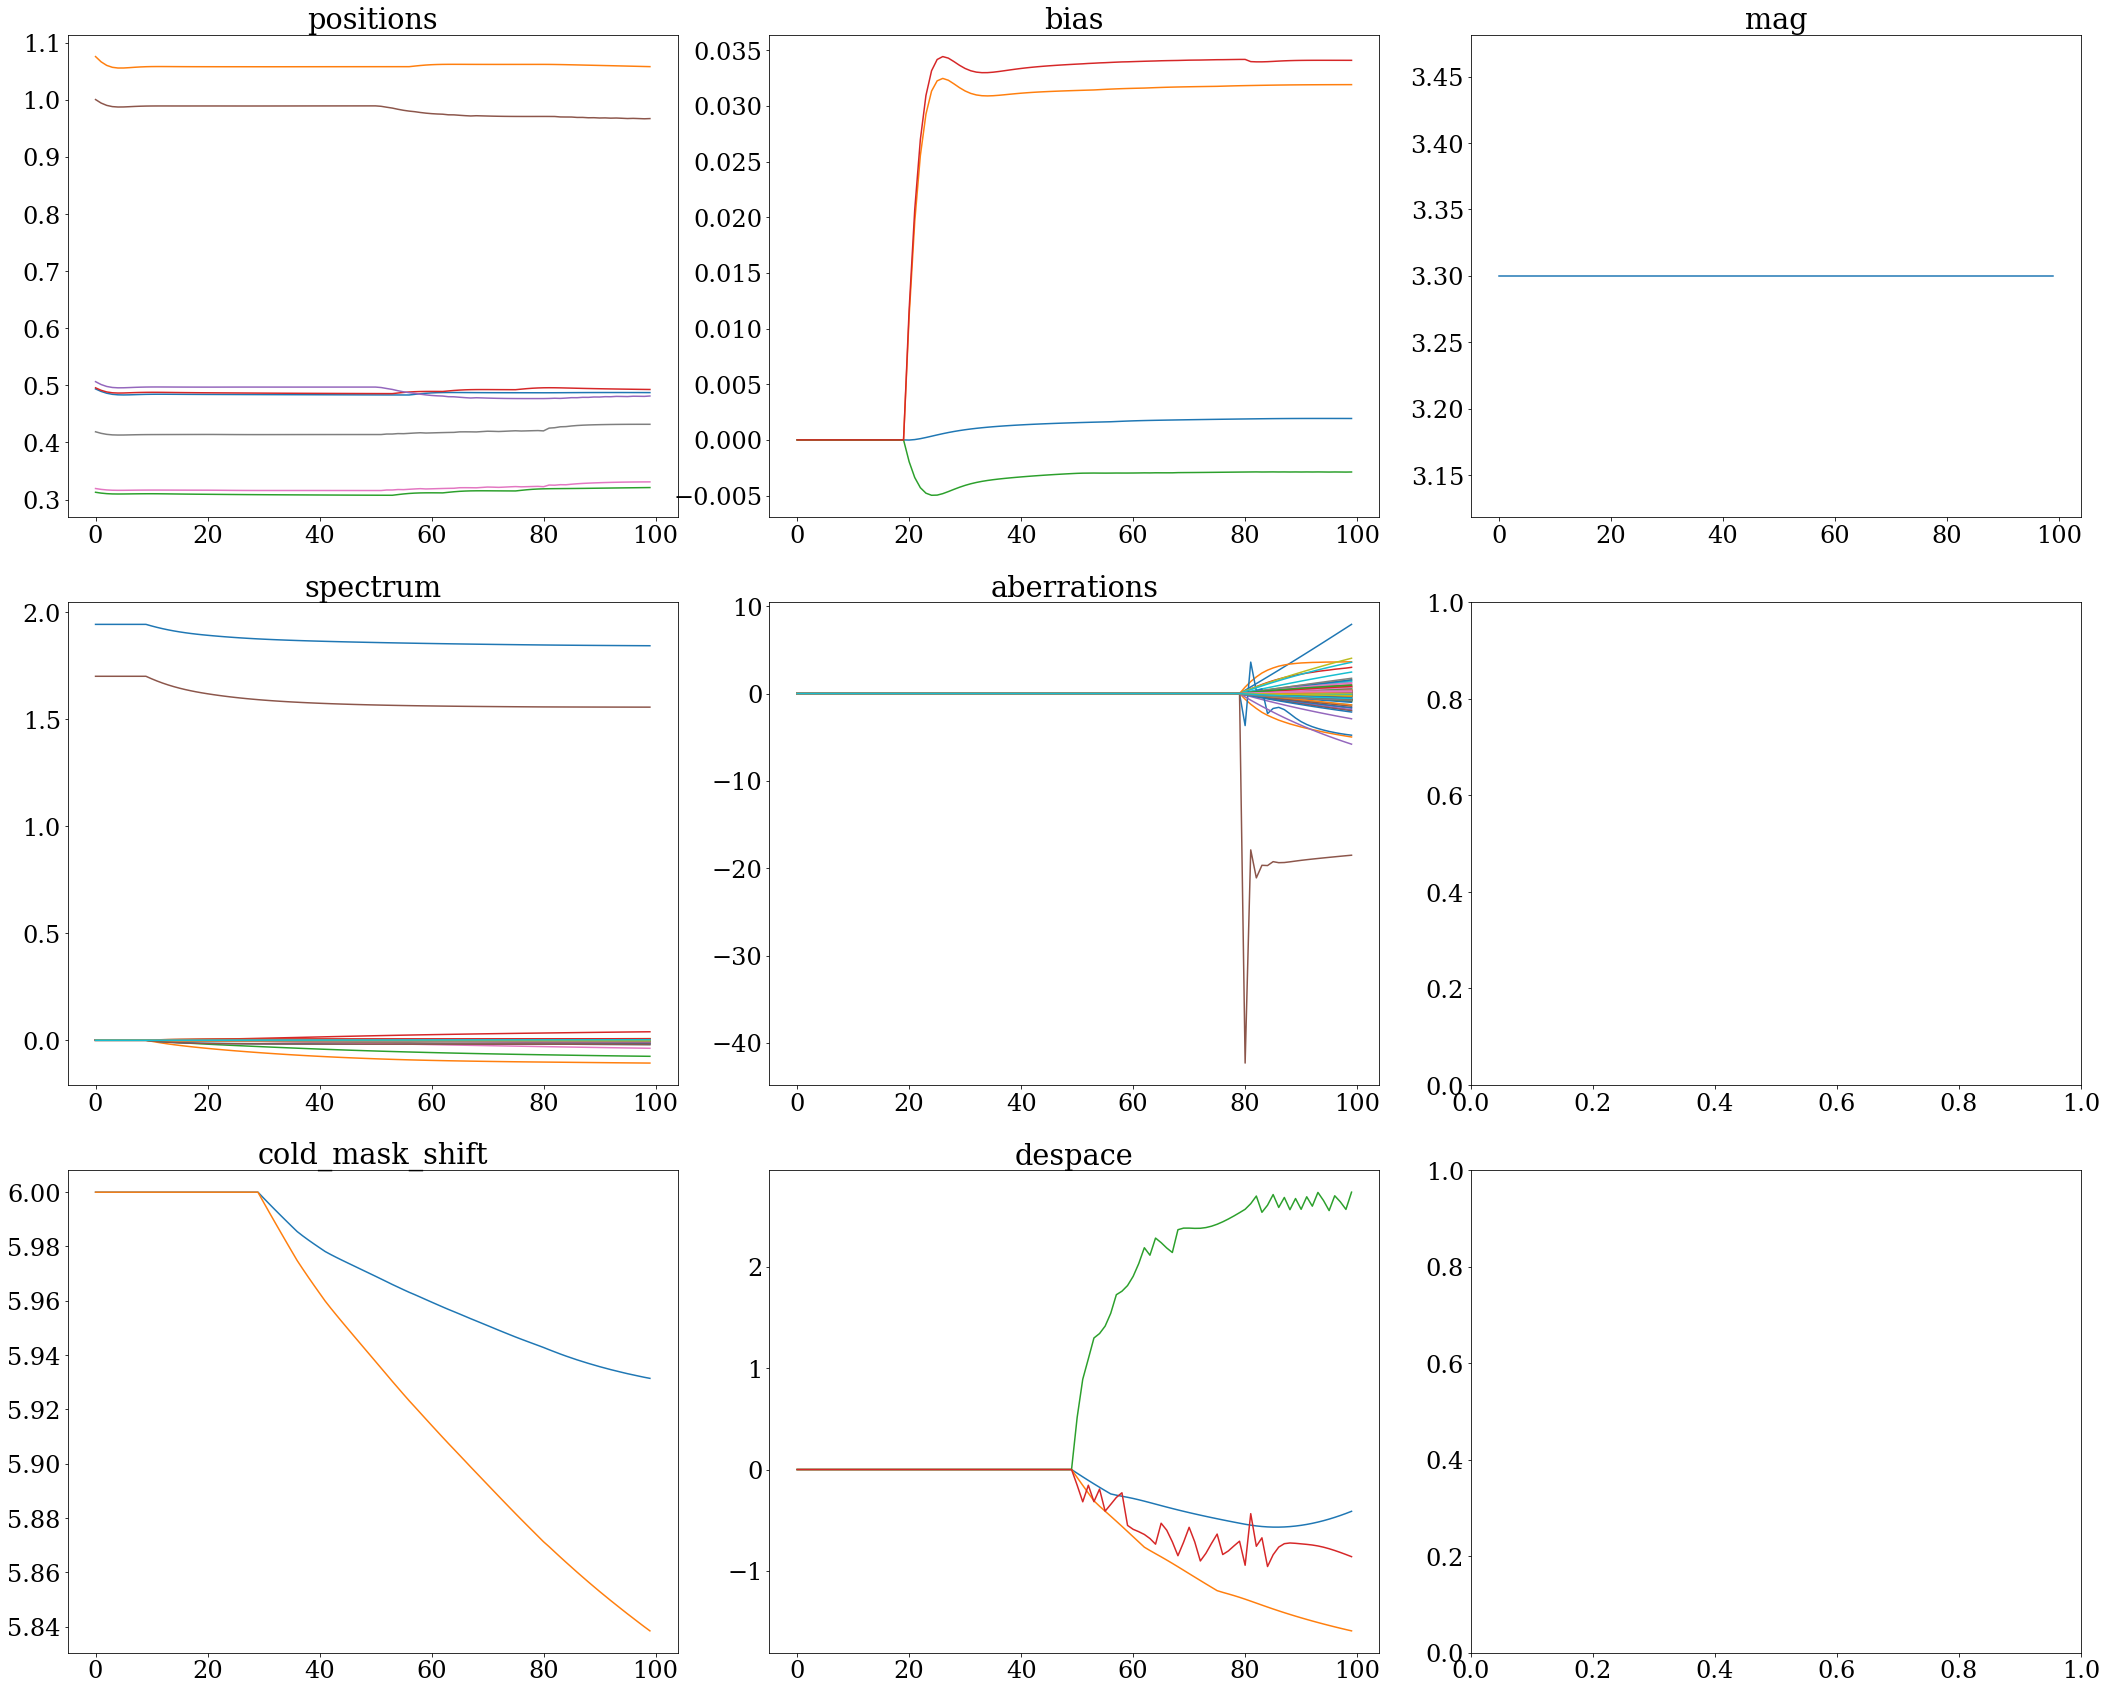

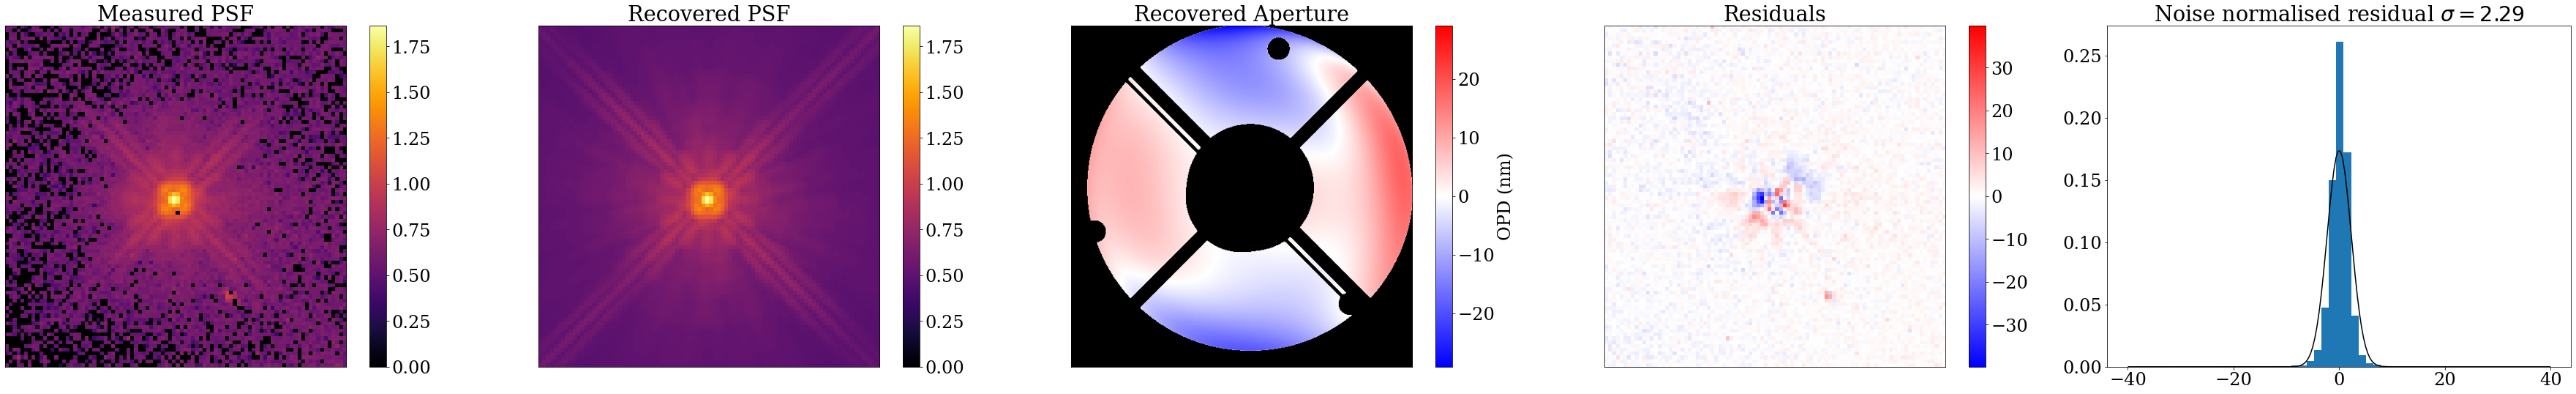

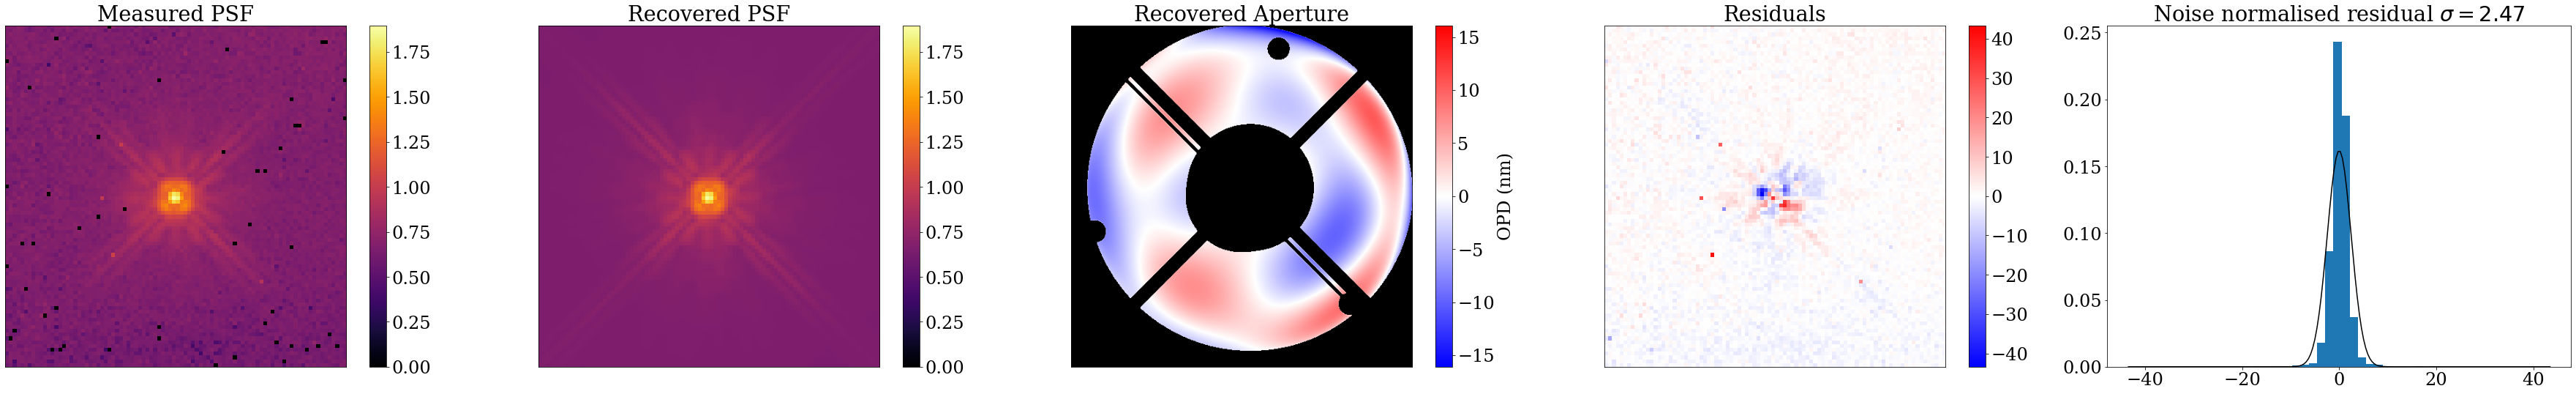

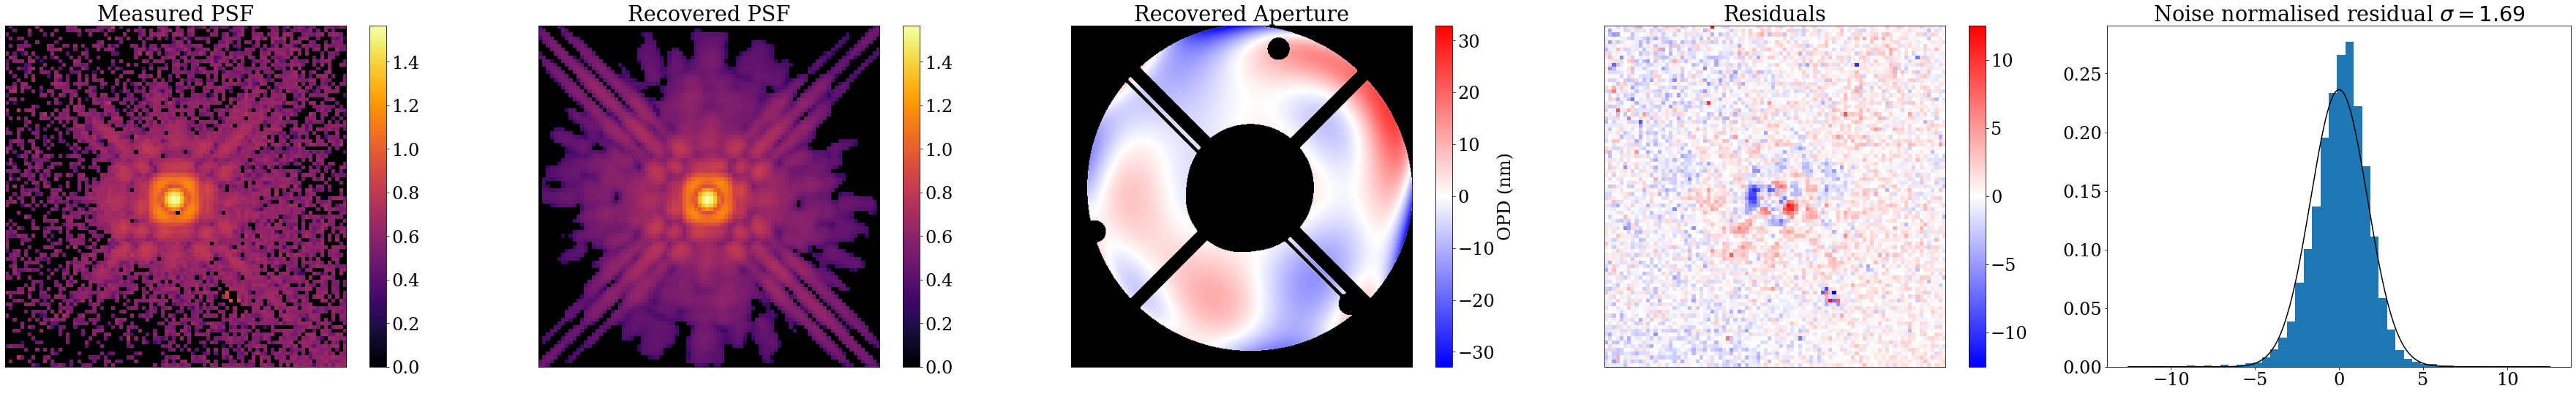

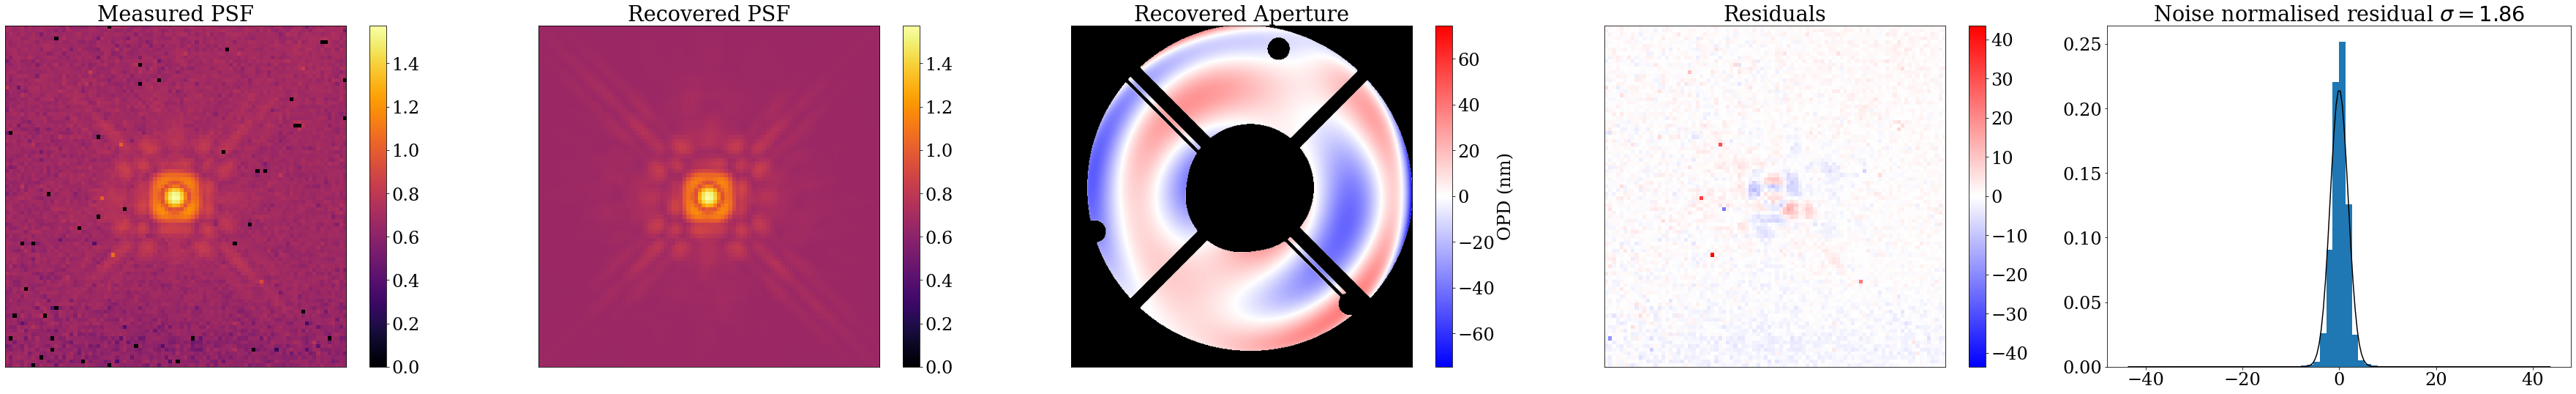

In [25]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [26]:
print(models[-1].params)

{'aberrations': {'n8ry01tkq': Array([ 7.9150114 , -0.42974976,  0.7712697 ,  0.12601502, -0.43543905,
       -0.30416262,  1.1734968 , -0.65849423,  0.2501046 ,  1.3272905 ,
        0.3043251 ,  0.16748747, -0.88503677,  0.28957132,  0.28821406,
       -0.298024  , -0.03337876,  0.179948  ,  0.47113952, -0.33645478,
        0.08637139,  0.19685897, -0.15216707,  0.32600835, -1.6857395 ,
       -0.32145086,  0.34581763, -0.20696945,  0.14377804,  0.1868477 ],      dtype=float32), 'n8ry01tmq': Array([-0.11271189, -0.08940423,  0.4986193 ,  0.69486743, -0.10471158,
       -0.89486647, -0.26509044,  0.08079541,  1.5674951 ,  1.4479339 ,
       -1.006909  , -0.70054185, -0.7702304 ,  0.9768832 ,  0.080376  ,
        0.10770173,  0.13723807, -0.6243148 ,  0.39463633, -0.6503818 ,
       -0.03579103, -0.22153597,  0.25323775, -0.01645564, -1.8531013 ,
       -1.9675654 ,  0.18355219, -0.7240711 ,  0.15630126, -0.40434152],      dtype=float32), 'n8ry03vbq': Array([ 1.5642836 , -4.9785266 ,  0.

In [27]:
models[-1].inject(model_single)

NICMOSModel(
  params={
    'aberrations':
    {
      'n8ry01tkq': f32[30],
      'n8ry01tmq': f32[30],
      'n8ry03vbq': f32[30],
      'n8ry03vcq': f32[30]
    },
    'bias':
    {
      'n8ry01tkq': f32[],
      'n8ry01tmq': f32[],
      'n8ry03vbq': f32[],
      'n8ry03vcq': f32[]
    },
    'cold_mask_rot': {'global': f32[]},
    'cold_mask_scale': {'global': f32[2]},
    'cold_mask_shear': {'global': f32[2]},
    'cold_mask_shift': {'global': f32[2]},
    'defocus':
    {
      'n8ry01tkq': f32[],
      'n8ry01tmq': f32[],
      'n8ry03vbq': f32[],
      'n8ry03vcq': f32[]
    },
    'despace':
    {
      'n8ry01tkq': f32[],
      'n8ry01tmq': f32[],
      'n8ry03vbq': f32[],
      'n8ry03vcq': f32[]
    },
    'jitter':
    {
      'n8ry01tkq': f32[],
      'n8ry01tmq': f32[],
      'n8ry03vbq': f32[],
      'n8ry03vcq': f32[]
    },
    'mag': f32[],
    'outer_radius': f32[],
    'positions':
    {
      'n8ry01tkq': f32[2],
      'n8ry01tmq': f32[2],
      'n8ry03vbq': f32

In [28]:
models[-1]

ModelParams(
  params={
    'aberrations':
    {
      'n8ry01tkq': f32[30],
      'n8ry01tmq': f32[30],
      'n8ry03vbq': f32[30],
      'n8ry03vcq': f32[30]
    },
    'bias':
    {
      'n8ry01tkq': f32[],
      'n8ry01tmq': f32[],
      'n8ry03vbq': f32[],
      'n8ry03vcq': f32[]
    },
    'cold_mask_shift': {'global': f32[2]},
    'despace':
    {
      'n8ry01tkq': f32[],
      'n8ry01tmq': f32[],
      'n8ry03vbq': f32[],
      'n8ry03vcq': f32[]
    },
    'mag': f32[],
    'positions':
    {
      'n8ry01tkq': f32[2],
      'n8ry01tmq': f32[2],
      'n8ry03vbq': f32[2],
      'n8ry03vcq': f32[2]
    },
    'spectrum': {'HZ4_F110W': f32[15], 'HZ4_F160W': f32[15]}
  }
)

In [29]:
groups

['positions',
 'spectrum',
 'cold_mask_shift',
 'bias',
 'aberrations',
 'despace',
 'mag']

In [30]:
#stop

In [31]:
#fsh = calc_fishers(models[-1].inject(model_single), exposures_single, groups, fisher_fn, recalculate=True, save=False)


In [32]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    res = np.sum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))
    return np.where(res==0.0, np.inf, res)

@eqx.filter_jit
def fun(params, args):
    exposures, model = args
    return loss_fn(params, exposures, model)

def optimise_optimistix(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]

    model_params = ModelParams({p: params.get(p) for p in things.keys()})

    solver = optx.BFGS(rtol=1e-6, atol=1e-6,verbose=frozenset({"step_size", "loss"}))
    sol = optx.minimise(fun, solver, model_params, (exposures, model), throw=False, max_steps=niter)
    
    return sol



In [33]:
sol = optimise_optimistix(models[-1], models[-1].inject(model_single), exposures_single, things, 500)
print(sol.value.params)
print(fun(sol.value, (exposures_single, model_single)), (losses[-1]))

Loss on this step: -44237.1171875, Loss on the last accepted step: 0.0, Step size: 1.0
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.5
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.25
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.125
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.0625
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.03125
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.015625
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.0078125
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.00390625
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.001953125
Loss on this step: inf, Loss on the last accepted step: -44237.1171875, Step size: 0.000976562

In [34]:
final_params = sol.value
# final_params = models[-1]

In [35]:
final_params.params

{'aberrations': {'n8ry01tkq': Array([ 8.173144  , -0.7039671 ,  3.0757818 ,  0.5265643 , -2.4193254 ,
         -1.6994606 ,  1.7889435 , -1.24262   ,  0.37836596,  2.1023104 ,
          0.5160506 ,  0.5385621 , -2.3954253 ,  1.3093125 ,  1.334701  ,
         -0.8964461 , -0.11510135,  0.2407993 ,  0.58761483, -0.48919758,
          0.14965254,  0.32512665, -0.23855661,  0.51489824, -2.8530493 ,
         -0.56295997,  0.67571455, -0.42905238,  0.3567274 ,  0.45756182],      dtype=float32),
  'n8ry01tmq': Array([-1.38440058e-01, -1.26619488e-01,  1.91922152e+00,  2.64444971e+00,
         -4.31507021e-01, -5.10486269e+00, -3.93256843e-01,  2.23048747e-01,
          2.43348312e+00,  2.34381080e+00, -1.81968319e+00, -1.77410114e+00,
         -1.96511090e+00,  4.49917316e+00,  3.25026900e-01,  2.03356147e-01,
          4.36542958e-01, -7.83215165e-01,  5.24352551e-01, -9.45762157e-01,
         -1.00143954e-01, -3.15593690e-01,  3.33410650e-01, -2.96312873e-03,
         -2.79828429e+00, -3.11

In [36]:
#sol.stats

2.2469323
2.0661123
1.6827722
1.8197016


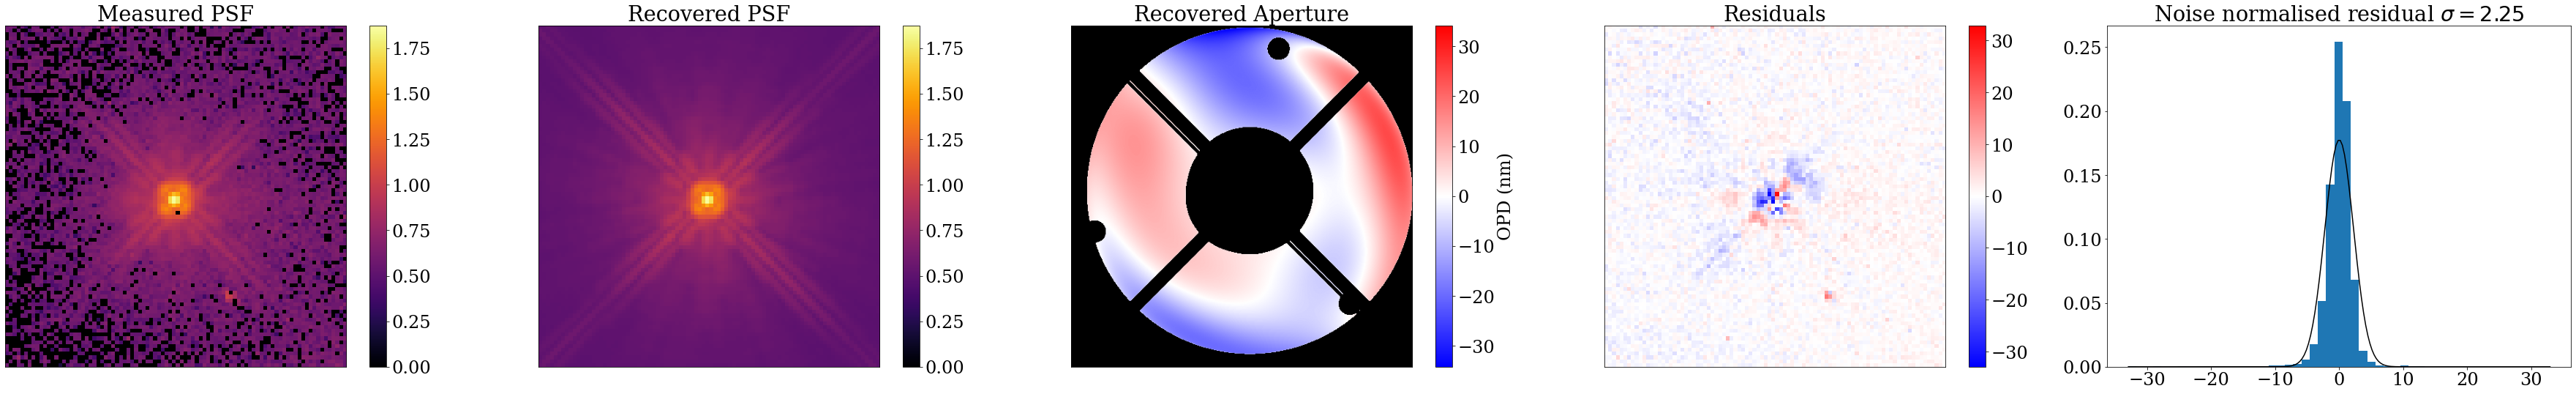

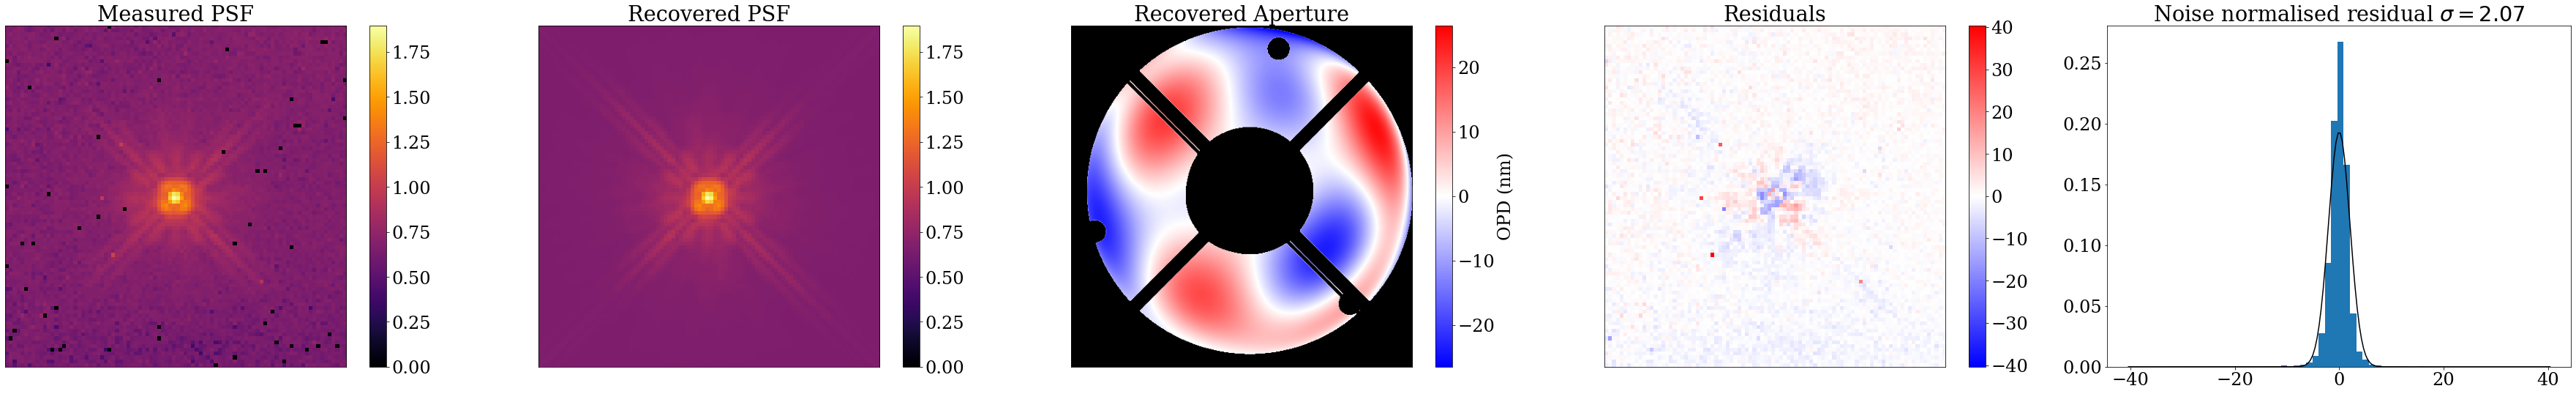

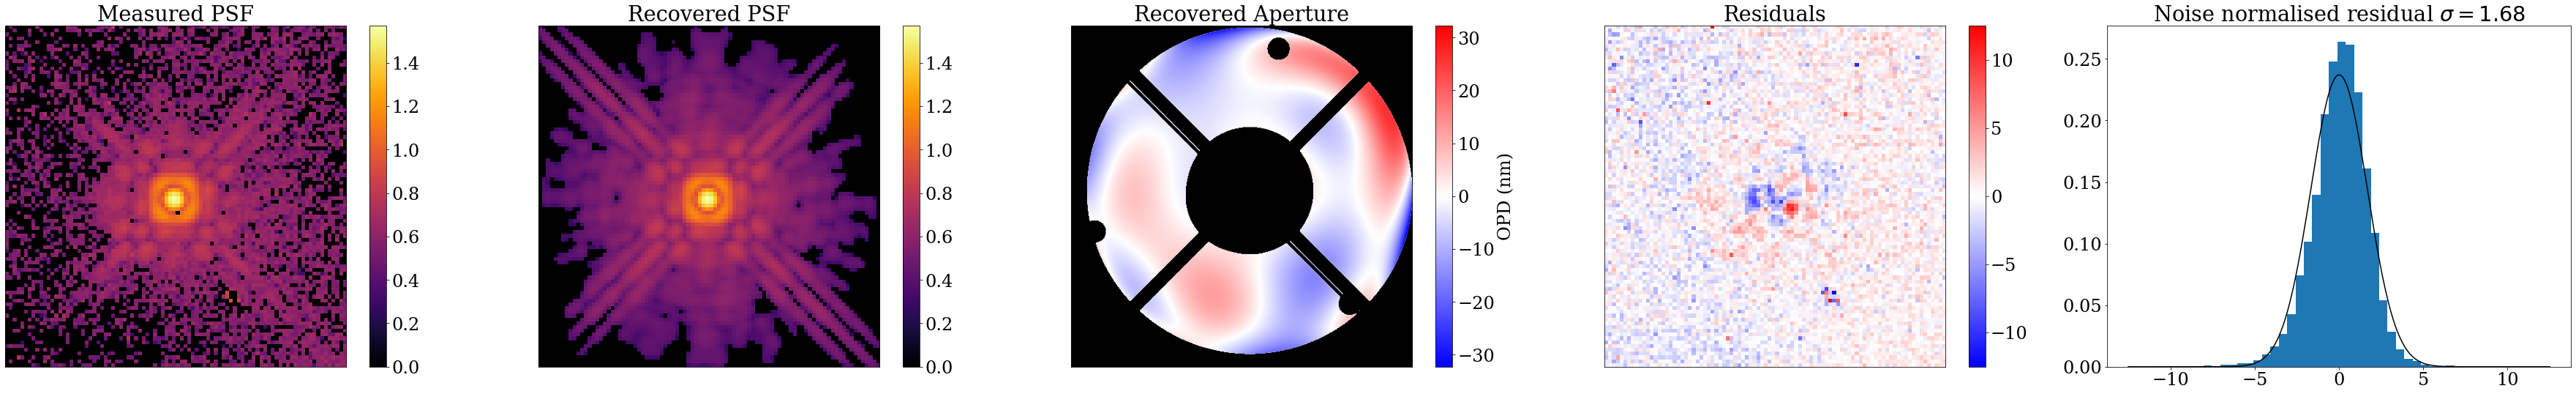

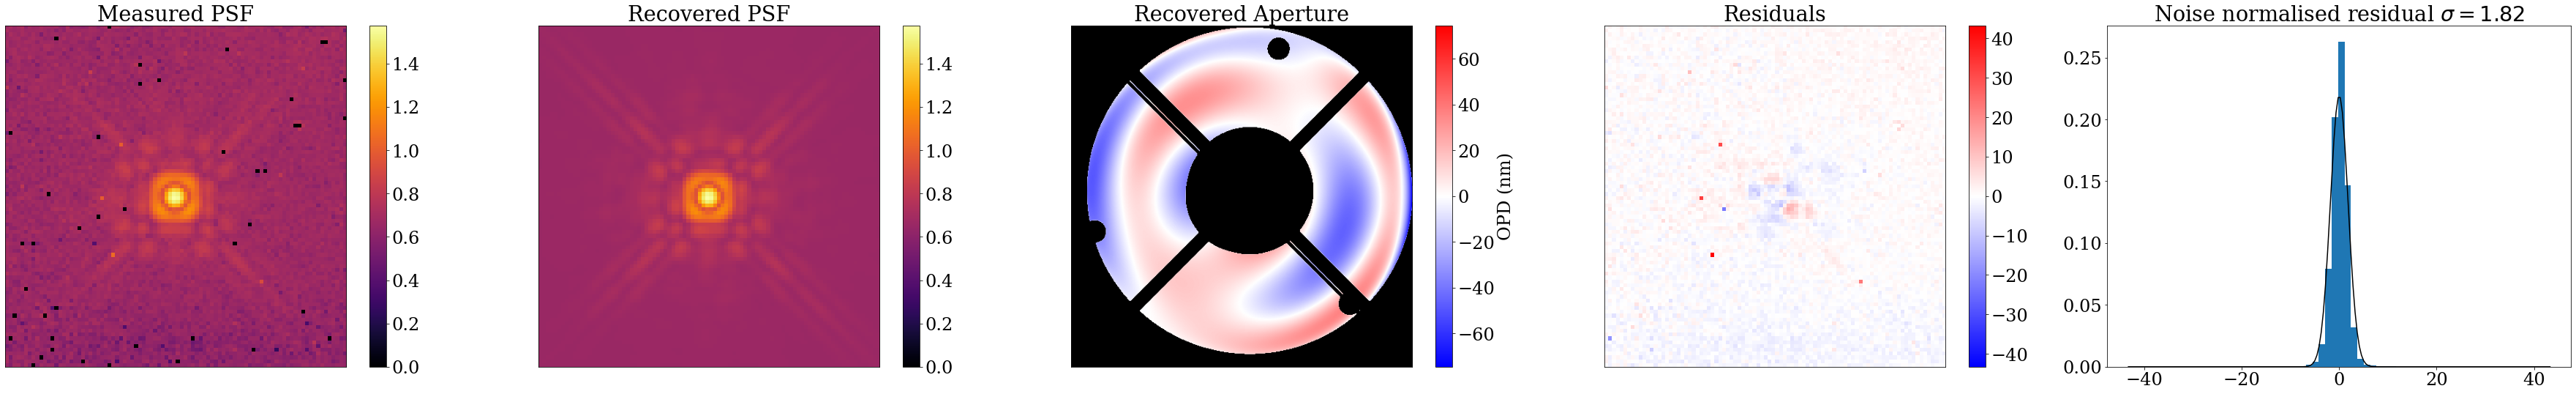

In [37]:
plot_comparison(final_params.inject((model_single)), final_params, exposures_single)

In [38]:
# calculate spectrum

In [39]:
fsh = calc_fishers(final_params.inject(model_single), exposures_single, ["spectrum"], fisher_fn, recalculate=True, save=False)
fsh

  0%|          | 0/4 [00:00<?, ?it/s]

{'n8ry01tkq.spectrum': Array([[ 1.33004610e+07, -4.11357650e+06, -2.99153275e+06,
          3.70545900e+06, -2.70993625e+06,  1.90579547e+05,
          8.32617125e+05, -3.37066156e+05, -7.38997875e+05,
          1.04785006e+06,  1.18619162e+06, -7.48499125e+05,
         -5.56424562e+05,  8.56382188e+04,  1.78980656e+05],
        [-4.11357600e+06,  2.75735775e+06,  1.50902925e+06,
         -1.49774275e+06,  8.23678812e+05,  2.01827312e+05,
          3.93723438e+03,  4.48458906e+04,  2.44883656e+05,
         -4.78944000e+05, -4.60894406e+05,  3.81338688e+05,
          1.57203891e+05, -1.75215723e+04, -4.09948516e+04],
        [-2.99153225e+06,  1.50902850e+06,  1.88532788e+06,
         -1.24991200e+06,  7.39422500e+05,  2.01929859e+05,
         -2.02098656e+05,  8.98520859e+04,  2.97692219e+05,
         -3.10963562e+05, -3.48531812e+05,  3.05798625e+05,
          1.99277125e+05, -4.77754883e+03, -6.34795859e+04],
        [ 3.70545900e+06, -1.49774200e+06, -1.24991250e+06,
          1.760

In [40]:
def populate_fisher_model(fishers, exposures, model_params):

    # Build the lr model structure
    params_dict = jax.tree.map(lambda x: np.zeros((x.size, x.size)), model_params).params

    # Loop over exposures
    for exp in exposures:

        # Loop over parameters
        for param in model_params.keys():

            # Check if the fishers have values for this exposure
            key = f"{exp.key}.{param}"
            if key not in fishers.keys():
                continue

            # Add the Fisher matrices
            if isinstance(params_dict[param], dict):
                params_dict[param][exp.get_key(param)] += fishers[key]
            else:
                params_dict[param] += fishers[key]

    fisher_params = model_params.set("params", params_dict)

    return fisher_params

In [41]:
fsh

{'n8ry01tkq.spectrum': Array([[ 1.33004610e+07, -4.11357650e+06, -2.99153275e+06,
          3.70545900e+06, -2.70993625e+06,  1.90579547e+05,
          8.32617125e+05, -3.37066156e+05, -7.38997875e+05,
          1.04785006e+06,  1.18619162e+06, -7.48499125e+05,
         -5.56424562e+05,  8.56382188e+04,  1.78980656e+05],
        [-4.11357600e+06,  2.75735775e+06,  1.50902925e+06,
         -1.49774275e+06,  8.23678812e+05,  2.01827312e+05,
          3.93723438e+03,  4.48458906e+04,  2.44883656e+05,
         -4.78944000e+05, -4.60894406e+05,  3.81338688e+05,
          1.57203891e+05, -1.75215723e+04, -4.09948516e+04],
        [-2.99153225e+06,  1.50902850e+06,  1.88532788e+06,
         -1.24991200e+06,  7.39422500e+05,  2.01929859e+05,
         -2.02098656e+05,  8.98520859e+04,  2.97692219e+05,
         -3.10963562e+05, -3.48531812e+05,  3.05798625e+05,
          1.99277125e+05, -4.77754883e+03, -6.34795859e+04],
        [ 3.70545900e+06, -1.49774200e+06, -1.24991250e+06,
          1.760

In [42]:
fm = populate_fisher_model(fsh, exposures_single, models[-1])

In [43]:
fm.get("spectrum.HZ4_F110W")

Array([[ 2.60414700e+07, -8.03045750e+06, -5.85353200e+06,
         7.24582000e+06, -5.30282750e+06,  3.79979938e+05,
         1.63276312e+06, -6.62842875e+05, -1.44616450e+06,
         2.04841775e+06,  2.32107700e+06, -1.46264612e+06,
        -1.08933675e+06,  1.67097781e+05,  3.49838375e+05],
       [-8.03045700e+06,  5.31911300e+06,  2.90323525e+06,
        -2.91949550e+06,  1.60482450e+06,  3.81286188e+05,
         2.40040625e+03,  9.23424766e+04,  4.67355000e+05,
        -9.28054188e+05, -8.92256875e+05,  7.37679625e+05,
         3.07454312e+05, -3.63497266e+04, -8.16857969e+04],
       [-5.85353200e+06,  2.90323375e+06,  3.50329900e+06,
        -2.38748675e+06,  1.44051650e+06,  3.62359750e+05,
        -3.85967250e+05,  1.72608594e+05,  5.60531625e+05,
        -5.97604625e+05, -6.71033562e+05,  5.80752750e+05,
         3.79268531e+05, -1.23341367e+04, -1.23867336e+05],
       [ 7.24581900e+06, -2.91949450e+06, -2.38748750e+06,
         3.23876525e+06, -1.79964225e+06, -2.80299281

In [60]:
cov_f110w = np.linalg.inv(fsh['n8ry01tkq.spectrum'])#+fsh['n8yj02wyq.spectrum'])
spectrum_err = np.diag(np.sqrt(np.abs(cov_f110w)))

cov_f160w = np.linalg.inv(fsh['n8ry03vbq.spectrum'])#+fsh['n8yj02wyq.spectrum'])


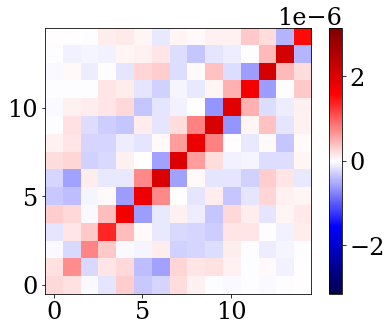

In [61]:
plt.imshow(np.linalg.inv(fm.get("spectrum.HZ4_F110W")), cmap='seismic', vmin=-np.max(np.abs(cov_f110w)), vmax=np.max(np.abs(cov_f110w)))
plt.colorbar()


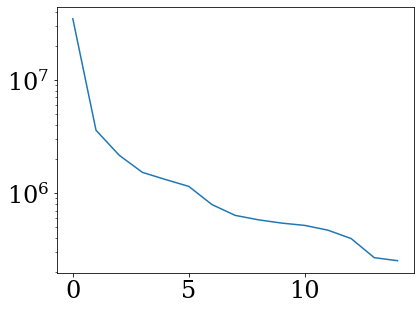

In [62]:
vals, vects = np.linalg.eig(fm.get("spectrum.HZ4_F110W"))#+fsh['n8yj02wyq.spectrum'])

order = np.argsort(vals)[::-1]

#plt.figure(figsize=(10,10))
#plt.xlabel("Coefficient")

#for i in range(5):
#    plt.plot(np.arange(npoly),np.real(vects[:,order[i]]), label=f"{i}")
#plt.legend()

plt.semilogy(np.sort(np.real(vals))[::-1])

In [63]:
#spec.filt_weights.sum()
#spec2.filt_weights.sum()

In [64]:
#(filt/(wv*1e6)).sum()/(filt2/(wv*1e6)).sum()

Text(0.5, 0, 'Wavelength (um)')

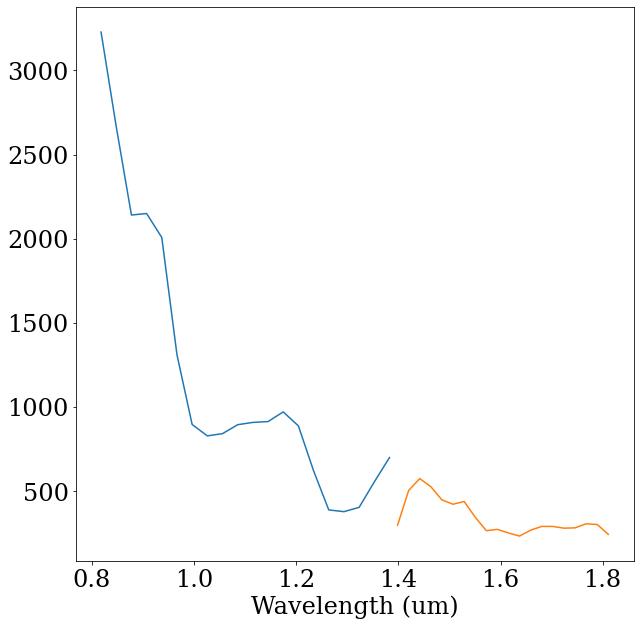

In [65]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

spec = CombinedBasisSpectrum(wv, filt, final_params.get("spectrum.HZ4_F110W"), spectrum_basis)

wv2, filt2 = calc_throughput("F160W", nwavels=nwavels)

spec2 = CombinedBasisSpectrum(wv2, filt2, final_params.get("spectrum.HZ4_F160W"), spectrum_basis)


sp = spec.spec_weights()/spec.flux*spec.proper_flux()/(wv*1e6)
sp2 = spec2.spec_weights()/spec2.flux*spec2.proper_flux()/(wv2*1e6)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv*1e6, sp)
plt.plot(wv2*1e6, sp2)

plt.xlabel("Wavelength (um)")


In [66]:
from scipy.optimize import curve_fit
from scipy.constants import h, c, k

def planck_wavelength(wav, T, scale, bg):
    """
    Planck's Law as a function of wavelength (m) and temperature (K).
    Returns intensity in arbitrary units with a scaling factor.
    """
    a = 2.0 * h * c**2
    b = h * c / (wav * k * T)
    intensity = scale * a / ( (wav**5) * (np.exp(b) - 1.0) ) + bg# * (wav/1e-6)
    return intensity

def rayleigh_jeans(wav, scale, bg):
    return scale/wav**4 + bg

In [67]:
wavels = np.concat((wv, wv2))
spectrum = np.concat((sp, sp2))

initial_guesses = [14500.0, 1e-12, 0.] 

# Perform the curve fit
popt, pcov = curve_fit(planck_wavelength, wavels, spectrum, p0=initial_guesses, maxfev=10000)
print(popt)


[3.52237884e+05 4.44815118e-13 1.04696553e+02]


In [68]:
from jax.numpy import linalg as la
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3


def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [69]:
popt

array([3.52237884e+05, 4.44815118e-13, 1.04696553e+02])

In [70]:
np.sqrt(pcov[0,0])

Array(3361134.5, dtype=float32)

In [71]:
np.round(153.2, -2)

Array(200., dtype=float32, weak_type=True)

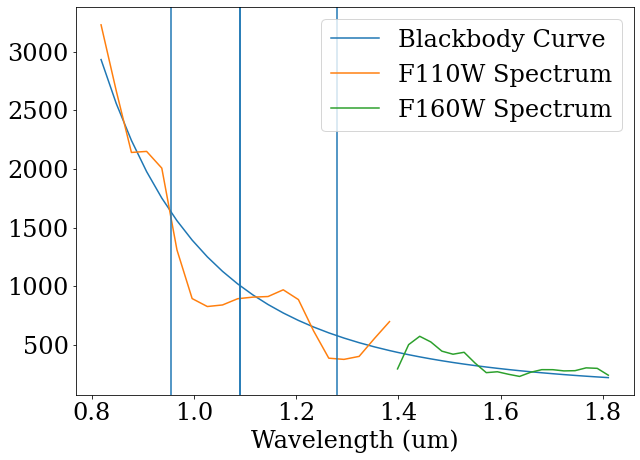

In [72]:
plt.figure(figsize=(10,7))

plt.plot(np.sort(wavels)*1e6, planck_wavelength(np.sort(wavels), *popt), label=fr"Blackbody Curve")# $T = {np.round(popt[0], -3):3.0f}$")
plt.plot(wv*1e6, sp, label = "F110W Spectrum")
plt.plot(wv2*1e6, sp2, label = "F160W Spectrum")

plt.axvline(1.28)
plt.axvline(1.09)
plt.axvline(0.955)
plt.axvline(1.09)


plt.xlabel("Wavelength (um)")
plt.legend()

Text(0.5, 0, 'Wavelength (um)')

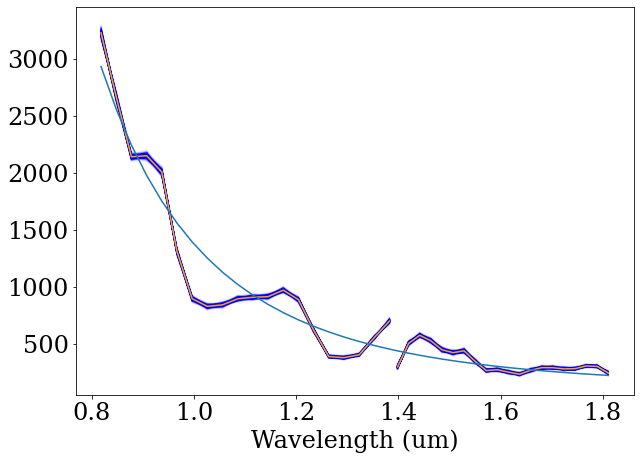

In [73]:
plt.figure(figsize=(10,7))

plt.plot(wv*1e6, sp, color='orange')
plt.plot(wv2*1e6, sp2, color='orange')

for i in range(1000):
    coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.HZ4_F110W"), nearestPD(cov_f110w))
    spec = CombinedBasisSpectrum(wv, filt, coeffs, spectrum_basis)#CombinedFourierSpectrum(wv, filt, coeffs)
    plt.plot(wv*1e6, spec.spec_weights()/spec.flux*spec.proper_flux()/(wv*1e6), color='b', alpha=0.01, zorder=0)

for i in range(1000):
    coeffs = numpy.random.multivariate_normal(final_params.get("spectrum.HZ4_F160W"), nearestPD(cov_f160w))
    spec = CombinedBasisSpectrum(wv2, filt2, coeffs, spectrum_basis)#CombinedFourierSpectrum(wv, filt, coeffs)
    plt.plot(wv2*1e6, spec.spec_weights()/spec.flux*spec.proper_flux()/(wv2*1e6), color='b', alpha=0.01, zorder=0)

plt.plot(wavels*1e6, planck_wavelength(wavels, *popt), label=fr"Blackbody Curve")# $T = {np.round(popt[0], -3):3.0f}$")


plt.xlabel("Wavelength (um)")
#plt.legend()